In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import torch
from model_builder import create_dnn_model, create_cnn_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from model_builder import SimpleDNN, SimpleCNN
import torch.nn.functional as F
from plotter import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

input_csv = "training_data/WSI_patch_embeddings_centered-224_adenocarcinoma_leiden_0.3_training-data.csv"
df = pd.read_csv(input_csv)

# Settings: 
do_pca = True

# Option 1: Use these as variance explained (0.8 = 80% variance)
# pca_dimensions = [0.8, 0.85, 0.9, 0.95]  

# Option 2: Convert to actual component numbers (current approach)
pca_dimensions = [0.8, 0.85, 0.9, 0.95]  # Will be converted to [80, 85, 90, 95] components


epochs = 1
output_base_path = "models/"
output_path_extra_desciptor = "" # leave empty if not needed; 
ebbeding_dim = 1536
result_subfolder = "leiden_0.3_adenocarcinoma_224"

Get pathology training data

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature_cols = [str(i) for i in range(1536)]
X = df[feature_cols].values.astype(np.float32)

scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)
y = LabelEncoder().fit_transform(df['label'].values).astype(np.int64)
labelEncoder = LabelEncoder().fit(df['label'].values)

# Create train/validation/test splits (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 * 0.8 = 0.2

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

df = pd.read_csv(input_csv)
X_pcaList = []
X_val_pcaList = []
X_test_pcaList = []

# Option 1: If pca_dimensions represents variance explained (0.8 = 80% variance)
# for variance_explained in pca_dimensions:
#     pca = PCA(n_components=variance_explained)  # This will automatically determine n_components
#     X_train_pca = pca.fit_transform(X_train)
#     X_val_pca = pca.transform(X_val)
#     X_test_pca = pca.transform(X_test)
#     print(f"PCA with {variance_explained*100}% variance explained uses {pca.n_components_} components")
    
# Option 2: If pca_dimensions should be actual component numbers
# Convert your current values to component numbers
#pca_component_numbers = [int(d * 100) for d in pca_dimensions]  # [80, 85, 90, 95] components
print(f"Using PCA component numbers: {pca_dimensions}")

for n_components in pca_dimensions:
    # Ensure we don't exceed the maximum possible components
    max_components = min(X_train.shape[0], X_train.shape[1])
    n_components = min(n_components, max_components)
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    print(f"PCA with {n_components} components, shape: {X_train_pca.shape}")
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.3f}")
    
    X_pcaList.append(X_train_pca)
    X_val_pcaList.append(X_val_pca)
    X_test_pcaList.append(X_test_pca)

Training set size: 2622 (60.0%)
Validation set size: 874 (20.0%)
Test set size: 875 (20.0%)
Using PCA component numbers: [0.8, 0.85, 0.9, 0.95]
Using PCA component numbers: [0.8, 0.85, 0.9, 0.95]
PCA with 0.8 components, shape: (2622, 139)
Variance explained: 0.801
PCA with 0.8 components, shape: (2622, 139)
Variance explained: 0.801
PCA with 0.85 components, shape: (2622, 198)
Variance explained: 0.850
PCA with 0.85 components, shape: (2622, 198)
Variance explained: 0.850
PCA with 0.9 components, shape: (2622, 296)
Variance explained: 0.900
PCA with 0.9 components, shape: (2622, 296)
Variance explained: 0.900
PCA with 0.95 components, shape: (2622, 490)
Variance explained: 0.950
PCA with 0.95 components, shape: (2622, 490)
Variance explained: 0.950


Train DNN model

In [3]:
dnn_list = []
acc_list_dnn = []
if do_pca:
    print("Using PCA for dimensionality reduction...")
    for i, X_train_pca in enumerate(X_pcaList):
        current_components = X_train_pca.shape[1]  # Get actual number of components
        print(f"Shape of PCA transformed data: {X_train_pca.shape}")
        
        dnn_output_path = f"{output_base_path}/dnn_pathology_model_pca_{current_components}.pth"
        model, acc = create_dnn_model(X_train_pca, X_val_pcaList[i], y_train, y_val, dnn_output_path, labelEncoder, 
                                   inputDim=current_components, epochs=epochs)
        dnn_list.append(model)
        acc_list_dnn.append(acc)
        print(f"Training set size: {X_train_pca.shape[0]}")
        print(f"Validation set size: {X_val_pcaList[i].shape[0]}")
        print("")
        
# Once without PCA        
dnn_output_path = f"{output_base_path}/dnn_pathology_model_without_pca.pth"
dnn_without_pca, acc_without_pca = create_dnn_model(X_train, X_val, y_train, y_val, dnn_output_path, labelEncoder, 
                                                  inputDim=ebbeding_dim, epochs=epochs)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Using PCA for dimensionality reduction...
Shape of PCA transformed data: (2622, 139)
DNN: Epoch 1 completed. Average Loss: 1.0785
DNN Accuracy: 0.802
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 198)
DNN: Epoch 1 completed. Average Loss: 1.0785
DNN Accuracy: 0.802
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 198)
DNN: Epoch 1 completed. Average Loss: 1.0890
DNN Accuracy: 0.802
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 296)
DNN: Epoch 1 completed. Average Loss: 1.0890
DNN Accuracy: 0.802
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 296)
DNN: Epoch 1 completed. Average Loss: 1.0699
DNN Accuracy: 0.808
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 490)
DNN: Epoch 1 completed. Average Loss: 1.0690
DNN Accuracy: 0.815
Training set size: 2622
Validation set size: 874

DNN: Epoch

Train CNN model

In [4]:
cnn_list = []
acc_list_cnn = []
if do_pca:
    print("Using PCA for dimensionality reduction...")
    for i, X_train_pca in enumerate(X_pcaList):
        current_components = X_train_pca.shape[1]  # Get actual number of components
        print(f"Shape of PCA transformed data: {X_train_pca.shape}")
        
        cnn_output_path = f"{output_base_path}/cnn_pathology_model_pca_{current_components}.pth"
        model, acc = create_cnn_model(X_train_pca, X_val_pcaList[i], y_train, y_val, cnn_output_path, labelEncoder, 
                                   inputDim=current_components, epochs=epochs)
        cnn_list.append(model)
        acc_list_cnn.append(acc)
        print(f"Training set size: {X_train_pca.shape[0]}")
        print(f"Validation set size: {X_val_pcaList[i].shape[0]}")
        print("")
        
# Once without PCA        
cnn_output_path = f"{output_base_path}/cnn_pathology_model_without_pca.pth"
cnn_without_pca, acc_without_pca = create_cnn_model(X_train, X_val, y_train, y_val, cnn_output_path, labelEncoder, 
                                                  inputDim=ebbeding_dim, epochs=epochs)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Using PCA for dimensionality reduction...
Shape of PCA transformed data: (2622, 139)
CNN: Epoch 1 completed. Average Loss: 1.6027
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 198)
CNN: Epoch 1 completed. Average Loss: 1.6027
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 198)
CNN: Epoch 1 completed. Average Loss: 1.5457
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 296)
CNN: Epoch 1 completed. Average Loss: 1.5457
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 296)
CNN: Epoch 1 completed. Average Loss: 1.6051
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 490)
CNN: Epoch 1 completed. Average Loss: 1.6051
Training set size: 2622
Validation set size: 874

Shape of PCA transformed data: (2622, 490)
CNN: Epoch 1 completed. Average Loss: 1.5221
Training set size: 2622
Validation set siz

~~Load trained models and perform dummy predictions~~ We dont extrnaly save the models


In [5]:
# # Load DNN model
# if do_pca:
#     input_dim = pca_components
# else:
#     input_dim = 1536
# dnn_list = []

# #for each pca_components in pca_dimensions load all models
# for pca_components in pca_dimensions:
#     dnn_output_path = f"{output_base_path}dnn_pathology_model_pca_{pca_components}.pth"
#     dnn_model = SimpleDNN(input_dim, len(np.unique(y_train)))
#     checkpoint_dnn = torch.load(dnn_output_path)
#     dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
#     dnn_list.append(dnn_model)
#     dnn_model.eval()


    
# # dnn_model = SimpleDNN(input_dim, len(np.unique(y_train)))
# # checkpoint_dnn = torch.load(dnn_output_path)
# # dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
# # dnn_model.eval()


In [6]:

# # Load CNN model
# cnn_model = SimpleCNN(len(np.unique(y_train)))
# checkpoint_cnn = torch.load(cnn_output_path)
# cnn_model.load_state_dict(checkpoint_cnn.get("state_dict", checkpoint_cnn))
# cnn_model.eval()

In [7]:
# # Load saved label classes from the DNN model checkpoint
# checkpoint = torch.load(dnn_output_path)
# if "label_classes" in checkpoint:
#     original_labels = np.array(checkpoint["label_classes"])

# # One sample demo predictions of DNN model
# sample_input = torch.tensor(X_test[0]).unsqueeze(0)  # Add batch dimension
# dnn_output = dnn_model(sample_input)
# dnn_pred_enc = F.softmax(dnn_output, dim=1).argmax(dim=1).item()
# dnn_pred_label = original_labels[dnn_pred_enc]
# true_label = original_labels[y_test[0]]
# print(f"DNN model prediction: {dnn_pred_label} (encoded: {dnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")

# # One sample demo predictions of CNN model
# sample_input = torch.tensor(X_test[0]).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
# #cnn_output = cnn_model(sample_input)
# #cnn_pred_enc = F.softmax(cnn_output, dim=1).argmax(dim=1).item()
# #cnn_pred_label = original_labels[cnn_pred_enc]
# #print(f"CNN model prediction: {cnn_pred_label} (encoded: {cnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")


In [8]:
print(df.columns)

Index(['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '1527', '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535',
       'label'],
      dtype='object', length=1539)


## Visualize Sample points

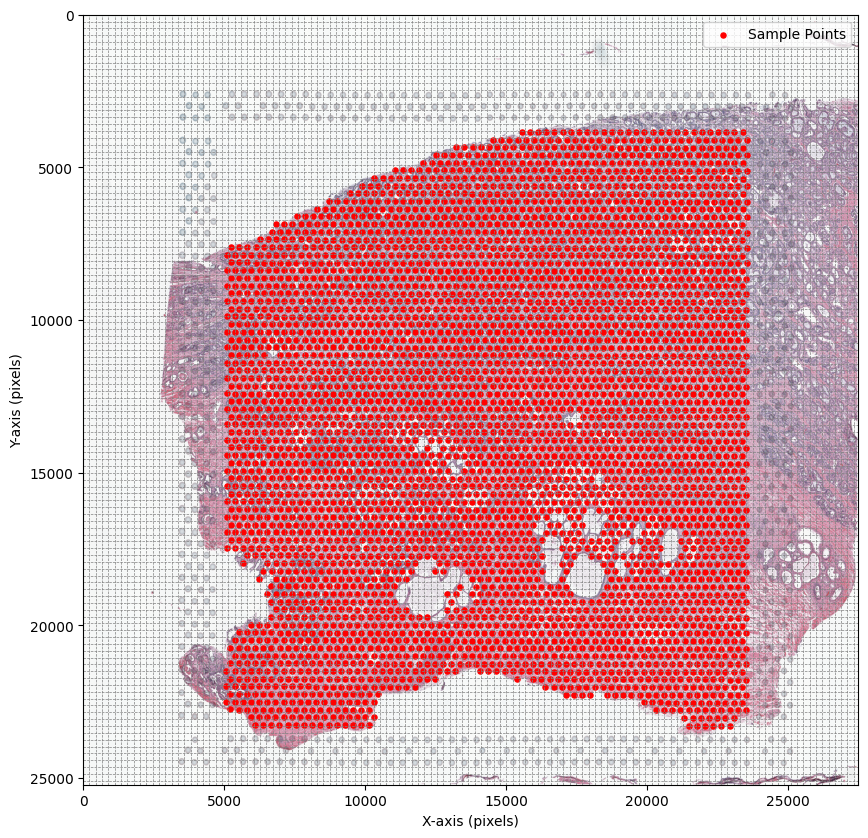

In [9]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples(image_path, df, 27482, 25219)



## Visualize Ground Truth Labels on Tissue Image

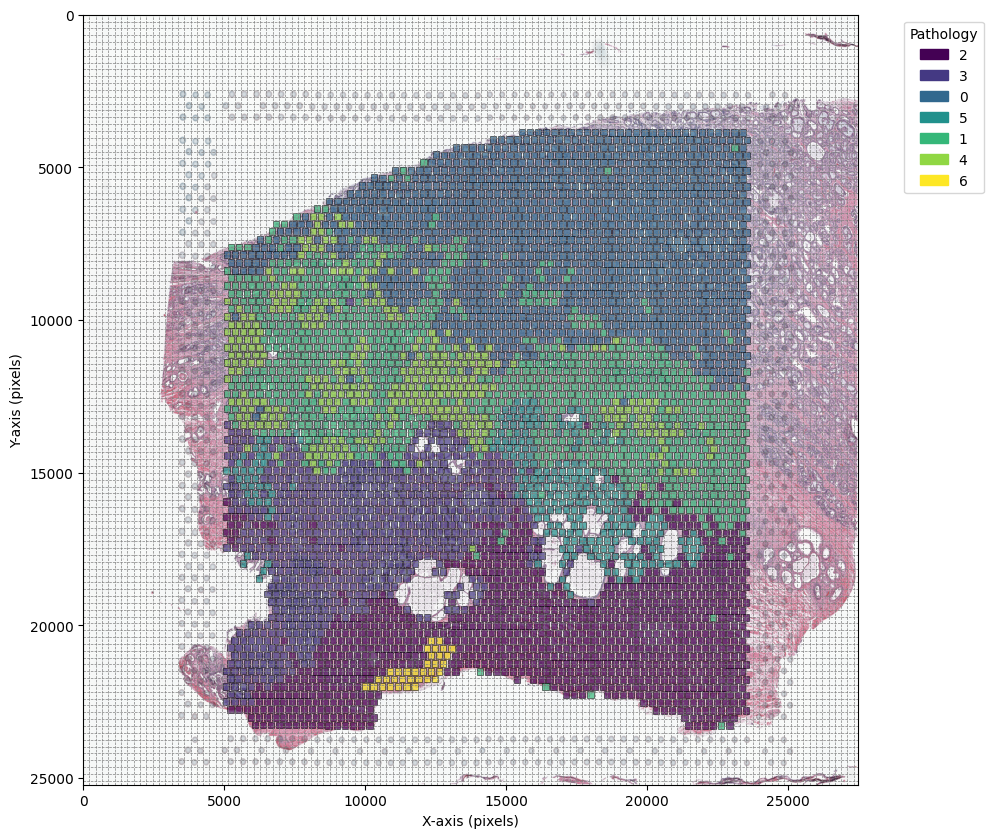

In [10]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df, 27482, 25219)


## Visualize predictions from DNN

In [11]:
original_labels = labelEncoder.classes_.tolist()

# Get predictions for validation data
list_of_prediced_labels = []
list_of_df_predicted_dnn = []
list_of_model_names = []
for i, dnn_model in enumerate(dnn_list):
    # Get validation predictions for each dnn_model
    X_val_tensor = torch.tensor(X_val_pcaList[i]).float()
    with torch.no_grad():
        dnn_outputs_temp = dnn_model(X_val_tensor)
        temp = F.softmax(dnn_outputs_temp, dim=1).argmax(dim=1)
        # list comprehension of predicted labels
        prediced_labels = [original_labels[label] for label in temp.numpy()]
        
        # Create dataframe with validation data indices for visualization
        val_indices = range(len(X_val_pcaList[i]))
        df_predicted_dnn = df.iloc[val_indices][['Patch_X', 'Patch_Y']].copy()
        df_predicted_dnn['label'] = prediced_labels
        
        list_of_prediced_labels.append(prediced_labels)
        list_of_model_names.append(f'dnn_pca_{i+1}')
        #df_predicted_dnn['pca_components'] = pca_components
        list_of_df_predicted_dnn.append(df_predicted_dnn)

In [12]:
from sklearn.metrics import adjusted_rand_score, f1_score, roc_auc_score

# Calculate ARI, F1 for each PCA model using validation set
ari_score_list = []
f1_score_list = []
for i, preds in enumerate(list_of_prediced_labels):
    f1 = f1_score(y_val, preds, average='weighted')  # Using validation labels
    ari_score = adjusted_rand_score(y_val, preds)  # Using validation labels
    ari_score_list.append(ari_score)
    f1_score_list.append(f1)

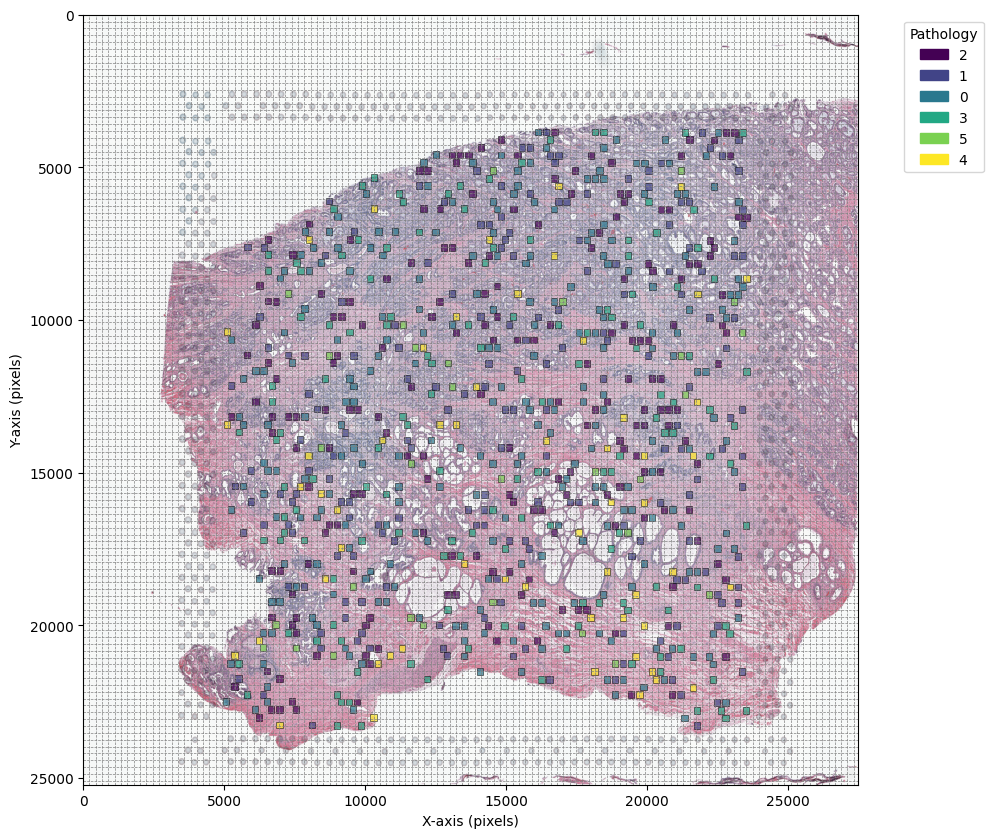

In [13]:
# Now visualize without PCA using validation set
X_val_tensor = torch.tensor(X_val).float()
with torch.no_grad():
	dnn_outputs = dnn_without_pca(X_val_tensor)
	dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
predicted_labels = [original_labels[label] for label in dnn_preds_enc.numpy()]

# Create dataframe with validation data for visualization
val_indices = range(len(X_val))
df_predicted_dnn = df.iloc[val_indices][['Patch_X', 'Patch_Y']].copy()
df_predicted_dnn['label'] = predicted_labels

# Calculate ARI for the model without PCA using validation set
ari_score_without_pca = adjusted_rand_score(y_val, predicted_labels)

image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df_predicted_dnn, 27482, 25219)

In [14]:
results_dir = f"results/{result_subfolder}"
os.makedirs(results_dir, exist_ok=True)
csv_path = f"results/{result_subfolder}/validation_scores.csv"

# Create a DataFrame with model performance metrics on validation set
results_data = []
    
# Add the model without PCA (using validation metrics)
results_data.append({
    'name': 'dnn_without_pca',
    'validation_accuracy': acc_without_pca,
    'validation_ari': ari_score_without_pca,
    'validation_f1': f1_score([original_labels[label] for label in y_val], predicted_labels, average='weighted')
})

print(f"Validation results saved to: {csv_path}")
for i, df_predicted_dnn in enumerate(list_of_df_predicted_dnn):
    output_path = f"results/{result_subfolder}/dnn_pca_{list_of_model_names[i]}_validation_predictions.png"
    print(f"Model {list_of_model_names[i]} \nValidation Accuracy: {acc_list_dnn[i]} ARI score: {ari_score_list[i]} F1 score: {f1_score_list[i]}")
    visualize_tissue_image_with_samples_color_labels(image_path, list_of_df_predicted_dnn[i], 27482, 25219, output_path=output_path)
    results_data.append({
        'name': list_of_model_names[i],
        'validation_accuracy': acc_list_dnn[i],
        'validation_ari': ari_score_list[i],
        'validation_f1': f1_score_list[i]
    })

# Write csv with validation metrics
results_df = pd.DataFrame(results_data)
results_df.to_csv(csv_path, index=False)

Validation results saved to: results/leiden_0.3_adenocarcinoma_224/validation_scores.csv
Model dnn_pca_1 
Validation Accuracy: 0.8020594965675057 ARI score: 0.6590190515198255 F1 score: 0.7882067926291582
Model dnn_pca_2 
Validation Accuracy: 0.8020594965675057 ARI score: 0.6578971940026892 F1 score: 0.7866581400176633
Model dnn_pca_2 
Validation Accuracy: 0.8020594965675057 ARI score: 0.6578971940026892 F1 score: 0.7866581400176633
Model dnn_pca_3 
Validation Accuracy: 0.8077803203661327 ARI score: 0.6671581612834486 F1 score: 0.7947796609565437
Model dnn_pca_3 
Validation Accuracy: 0.8077803203661327 ARI score: 0.6671581612834486 F1 score: 0.7947796609565437
Model dnn_pca_4 
Validation Accuracy: 0.8146453089244852 ARI score: 0.681541001828081 F1 score: 0.8001067681002448
Model dnn_pca_4 
Validation Accuracy: 0.8146453089244852 ARI score: 0.681541001828081 F1 score: 0.8001067681002448


# Visualize CNN output

In [15]:
original_labels = labelEncoder.classes_.tolist()

# Get predictions for validation data
list_of_prediced_labels = []
list_of_df_predicted_cnn = []
list_of_model_names_cnn = []
for i, cnn_model in enumerate(cnn_list):
    # Get validation predictions for each cnn_model
    X_val_tensor = torch.tensor(X_val_pcaList[i]).float()
    with torch.no_grad():
        cnn_outputs_temp = cnn_model(X_val_tensor.unsqueeze(1))
        temp = F.softmax(cnn_outputs_temp, dim=1).argmax(dim=1)
        # list comprehension of predicted labels
        prediced_labels = [original_labels[label] for label in temp.numpy()]
        
        # Create dataframe with validation data indices for visualization
        val_indices = range(len(X_val_pcaList[i]))
        df_predicted_cnn = df.iloc[val_indices][['Patch_X', 'Patch_Y']].copy()
        df_predicted_cnn['label'] = prediced_labels
        
        list_of_prediced_labels.append(prediced_labels)
        list_of_model_names_cnn.append(f'cnn_pca_{i+1}')
        #df_predicted_cnn['pca_components'] = pca_components
        list_of_df_predicted_cnn.append(df_predicted_cnn)

In [16]:
from sklearn.metrics import adjusted_rand_score, f1_score

# Calculate ARI, F1 for each PCA model using validation set
ari_score_list_cnn = []
f1_score_list_cnn = []
for i, preds in enumerate(list_of_prediced_labels):
    f1 = f1_score(y_val, preds, average='weighted')  # Using validation labels
    ari_score = adjusted_rand_score(y_val, preds)  # Using validation labels
    ari_score_list_cnn.append(ari_score)
    f1_score_list_cnn.append(f1)

In [17]:
results_dir = f"results/{result_subfolder}"
os.makedirs(results_dir, exist_ok=True)
csv_path = f"results/{result_subfolder}/cnn_validation_scores.csv"

# Create a DataFrame with model performance metrics on validation set
results_data = []
    
# Add the model without PCA (using validation metrics)
results_data.append({
    'name': 'cnn_without_pca',
    'validation_accuracy': acc_without_pca,
    'validation_ari': ari_score_without_pca,
    'validation_f1': f1_score([original_labels[label] for label in y_val], predicted_labels, average='weighted')
})

print(f"CNN validation results saved to: {csv_path}")
for i, df_predicted_cnn in enumerate(list_of_df_predicted_cnn):
    output_path = f"results/{result_subfolder}/cnn_pca_{list_of_model_names_cnn[i]}_validation_predictions.png"
    print(f"Model {list_of_model_names_cnn[i]} \nValidation Accuracy: {acc_list_cnn[i]} ARI score: {ari_score_list_cnn[i]} F1 score: {f1_score_list_cnn[i]}")
    visualize_tissue_image_with_samples_color_labels(image_path, list_of_df_predicted_cnn[i], 27482, 25219, output_path=output_path)
    results_data.append({
        'name': list_of_model_names_cnn[i],
        'validation_accuracy': acc_list_cnn[i],
        'validation_ari': ari_score_list_cnn[i],
        'validation_f1': f1_score_list_cnn[i]
    })

# Write csv with validation metrics
results_df = pd.DataFrame(results_data)
results_df.to_csv(csv_path, index=False)

CNN validation results saved to: results/leiden_0.3_adenocarcinoma_224/cnn_validation_scores.csv
Model cnn_pca_1 
Validation Accuracy: 0.6350114416475973 ARI score: 0.3726220082758395 F1 score: 0.5841201419223419
Model cnn_pca_2 
Validation Accuracy: 0.5938215102974829 ARI score: 0.3069298663777831 F1 score: 0.5341370947505432
Model cnn_pca_2 
Validation Accuracy: 0.5938215102974829 ARI score: 0.3069298663777831 F1 score: 0.5341370947505432
Model cnn_pca_3 
Validation Accuracy: 0.5778032036613272 ARI score: 0.2887755085135517 F1 score: 0.5111634071572357
Model cnn_pca_3 
Validation Accuracy: 0.5778032036613272 ARI score: 0.2887755085135517 F1 score: 0.5111634071572357
Model cnn_pca_4 
Validation Accuracy: 0.6624713958810069 ARI score: 0.44747187870424193 F1 score: 0.6034313469858464
Model cnn_pca_4 
Validation Accuracy: 0.6624713958810069 ARI score: 0.44747187870424193 F1 score: 0.6034313469858464


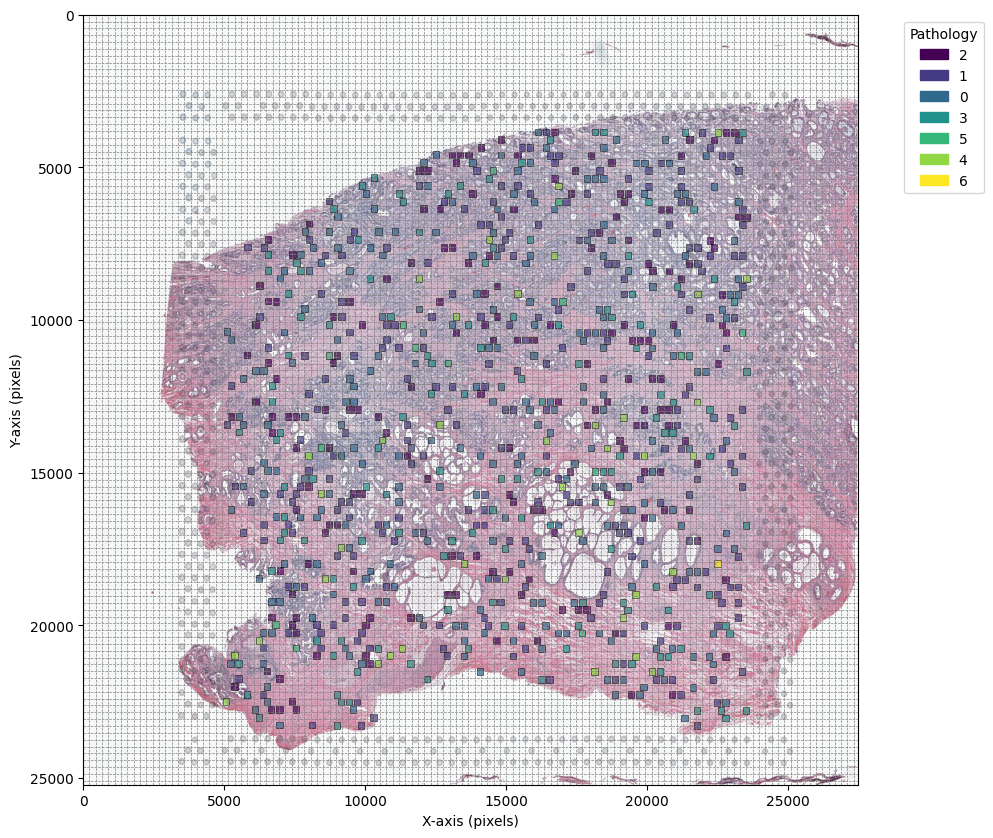

In [18]:
# Now visualize without PCA using validation set
X_val_tensor = torch.tensor(X_val).float()
with torch.no_grad():
	cnn_outputs = cnn_without_pca(X_val_tensor.unsqueeze(1))
	cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)
predicted_labels = [original_labels[label] for label in cnn_preds_enc.numpy()]

# Create dataframe with validation data for visualization
val_indices = range(len(X_val))
df_predicted_cnn = df.iloc[val_indices][['Patch_X', 'Patch_Y']].copy()
df_predicted_cnn['label'] = predicted_labels

# Calculate ARI for the model without PCA using validation set
ari_score_without_pca = adjusted_rand_score(y_val, predicted_labels)

image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df_predicted_cnn, 27482, 25219)

# Final Test Set Evaluation

Now that we've developed and tuned our models using the validation set, we can perform final evaluation on the test set. This gives us an unbiased estimate of model performance.

In [19]:
# Final evaluation on test set for DNN models
print("=== FINAL TEST SET EVALUATION - DNN MODELS ===")

# Evaluate DNN models with PCA on test set
test_results_dnn = []
for i, dnn_model in enumerate(dnn_list):
    X_test_tensor = torch.tensor(X_test_pcaList[i]).float()
    with torch.no_grad():
        dnn_outputs = dnn_model(X_test_tensor)
        dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
    
    predicted_labels = [original_labels[label] for label in dnn_preds_enc.numpy()]
    
    # Calculate test metrics
    test_ari = adjusted_rand_score(y_test, predicted_labels)
    test_f1 = f1_score(y_test, predicted_labels, average='weighted')
    
    # Calculate test accuracy manually
    correct = (dnn_preds_enc.numpy() == y_test).sum()
    test_accuracy = correct / len(y_test)
    
    test_results_dnn.append({
        'model': f'dnn_pca_{i+1}',
        'test_accuracy': test_accuracy,
        'test_ari': test_ari,
        'test_f1': test_f1
    })
    
    print(f"DNN PCA {i+1} - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Evaluate DNN without PCA on test set
X_test_tensor = torch.tensor(X_test).float()
with torch.no_grad():
    dnn_outputs = dnn_without_pca(X_test_tensor)
    dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)

predicted_labels = [original_labels[label] for label in dnn_preds_enc.numpy()]
test_ari = adjusted_rand_score(y_test, predicted_labels)
test_f1 = f1_score(y_test, predicted_labels, average='weighted')
correct = (dnn_preds_enc.numpy() == y_test).sum()
test_accuracy = correct / len(y_test)

test_results_dnn.append({
    'model': 'dnn_without_pca',
    'test_accuracy': test_accuracy,
    'test_ari': test_ari,
    'test_f1': test_f1
})

print(f"DNN without PCA - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

=== FINAL TEST SET EVALUATION - DNN MODELS ===
DNN PCA 1 - Test Accuracy: 0.810, ARI: 0.670, F1: 0.797
DNN PCA 2 - Test Accuracy: 0.798, ARI: 0.651, F1: 0.783
DNN PCA 3 - Test Accuracy: 0.819, ARI: 0.686, F1: 0.808
DNN PCA 4 - Test Accuracy: 0.809, ARI: 0.683, F1: 0.795
DNN without PCA - Test Accuracy: 0.831, ARI: 0.705, F1: 0.824


In [20]:
# Final evaluation on test set for CNN models
print("\n=== FINAL TEST SET EVALUATION - CNN MODELS ===")

# Evaluate CNN models with PCA on test set
test_results_cnn = []
for i, cnn_model in enumerate(cnn_list):
    X_test_tensor = torch.tensor(X_test_pcaList[i]).float()
    with torch.no_grad():
        cnn_outputs = cnn_model(X_test_tensor.unsqueeze(1))
        cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)
    
    predicted_labels = [original_labels[label] for label in cnn_preds_enc.numpy()]
    
    # Calculate test metrics
    test_ari = adjusted_rand_score(y_test, predicted_labels)
    test_f1 = f1_score(y_test, predicted_labels, average='weighted')
    
    # Calculate test accuracy manually
    correct = (cnn_preds_enc.numpy() == y_test).sum()
    test_accuracy = correct / len(y_test)
    
    test_results_cnn.append({
        'model': f'cnn_pca_{i+1}',
        'test_accuracy': test_accuracy,
        'test_ari': test_ari,
        'test_f1': test_f1
    })
    
    print(f"CNN PCA {i+1} - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Evaluate CNN without PCA on test set
X_test_tensor = torch.tensor(X_test).float()
with torch.no_grad():
    cnn_outputs = cnn_without_pca(X_test_tensor.unsqueeze(1))
    cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)

predicted_labels = [original_labels[label] for label in cnn_preds_enc.numpy()]
test_ari = adjusted_rand_score(y_test, predicted_labels)
test_f1 = f1_score(y_test, predicted_labels, average='weighted')
correct = (cnn_preds_enc.numpy() == y_test).sum()
test_accuracy = correct / len(y_test)

test_results_cnn.append({
    'model': 'cnn_without_pca',
    'test_accuracy': test_accuracy,
    'test_ari': test_ari,
    'test_f1': test_f1
})

print(f"CNN without PCA - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")


=== FINAL TEST SET EVALUATION - CNN MODELS ===
CNN PCA 1 - Test Accuracy: 0.654, ARI: 0.427, F1: 0.588
CNN PCA 2 - Test Accuracy: 0.622, ARI: 0.359, F1: 0.552
CNN PCA 3 - Test Accuracy: 0.600, ARI: 0.329, F1: 0.527
CNN PCA 4 - Test Accuracy: 0.674, ARI: 0.457, F1: 0.608
CNN without PCA - Test Accuracy: 0.783, ARI: 0.606, F1: 0.767
CNN without PCA - Test Accuracy: 0.783, ARI: 0.606, F1: 0.767


In [21]:
# Save final test results
print("\n=== SAVING FINAL TEST RESULTS ===")

# Combine all test results
all_test_results = test_results_dnn + test_results_cnn

# Save to CSV
test_results_df = pd.DataFrame(all_test_results)
test_csv_path = f"results/{result_subfolder}/final_test_scores.csv"
test_results_df.to_csv(test_csv_path, index=False)

print(f"Final test results saved to: {test_csv_path}")
print("\nFinal Test Results Summary:")
print(test_results_df.to_string(index=False))


=== SAVING FINAL TEST RESULTS ===
Final test results saved to: results/leiden_0.3_adenocarcinoma_224/final_test_scores.csv

Final Test Results Summary:
          model  test_accuracy  test_ari  test_f1
      dnn_pca_1       0.810286  0.670458 0.797377
      dnn_pca_2       0.797714  0.650737 0.783397
      dnn_pca_3       0.819429  0.685901 0.807966
      dnn_pca_4       0.809143  0.682702 0.794583
dnn_without_pca       0.830857  0.704675 0.823845
      cnn_pca_1       0.653714  0.427084 0.588094
      cnn_pca_2       0.621714  0.358561 0.551967
      cnn_pca_3       0.600000  0.329147 0.527474
      cnn_pca_4       0.674286  0.457162 0.608025
cnn_without_pca       0.782857  0.606237 0.766658
